## Modelo de Machine Learning - Prevenção de Fraudes
Análise Exploratória
Tratamento de valores nulos
Análise estatística dos dados
Engenharia de Atributos
Gráficos
Outliers
Normalização e padronização dos dados
Balanceamento da variável Target
OneHotEncoding
Criação, treino e teste de modelos preditivos com 3 algoritmos diferentes (Random Forest, Suport Vector e KNN)
GridSearch para ajustes de hiperparametros automáticos e treino de mais de 1000 modelos
Análise dos pesos das melhores variáveis

### Imports

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

### Importação dos Dados e Análise Exploratória

In [2]:
# Importação dos dados
df = pd.read_csv('dados_coletados.csv')

In [3]:
# Visão geral dos dados
df.head()

,Contrato,Idade,Sexo,Valor_Renda,UF_Cliente,Perc_Juros,Prazo_Emprestimo,Data_Contratacao,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Escolaridade,Possui_Patrimonio,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago,Possivel_Fraude
0,322090928715,42,M,4000.00,MA,17.00,140,2022-11-18,143,160000.00,184000.00,2,1,1,2,SOLTEIRO(A),NaN,N,0.00,10,284.00,187861.70,1617.36,Sim
1,321990634715,31,M,3000.00,MA,20.00,28,2021-07-23,0,14000.00,16100.00,2,1,1,1,CASADO (A),NaN,N,0.00,26,771.00,16615.93,1239.98,Sim
2,321965373715,36,F,2100.00,SP,24.00,180,2021-04-01,149,60000.00,69000.00,4,1,0,1,CASADO (A),Nenhum,N,0.00,27,802.00,74443.40,1346.64,Sim
3,321967133715,28,M,2155.00,DF,19.00,190,2021-04-10,159,180000.00,207000.00,29,28,0,2,SOLTEIRO(A),Nenhum,N,0.00,2,41.00,196812.41,22713.63,Nao
4,322098744715,21,F,4300.00,MG,22.00,100,2022-12-28,94,30000.00,34500.00,4,3,0,1,SOLTEIRO(A),Ensino Médio,N,0.00,6,162.00,36114.39,900.80,Sim


In [4]:
# Tamanho da base de dados
df.shape

(80143, 24)

In [5]:
# Período dos dados
dt_inicio = pd.to_datetime(df['Data_Contratacao']).dt.date.min()
dt_fim = pd.to_datetime(df['Data_Contratacao']).dt.date.max()
print('O período analisado é de', dt_inicio, 'a', dt_fim)

O período analisado é de 2020-11-25 a 2023-02-22


In [6]:
# Tipo dos dados
df.info(verbose=True) # verbose=True para impedir barra de rolagem

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80143 entries, 0 to 80142
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Contrato                          80143 non-null  int64  
 1   Idade                             80143 non-null  int64  
 2   Sexo                              80143 non-null  object 
 3   Valor_Renda                       80143 non-null  float64
 4   UF_Cliente                        80143 non-null  object 
 5   Perc_Juros                        80143 non-null  float64
 6   Prazo_Emprestimo                  80143 non-null  int64  
 7   Data_Contratacao                  80143 non-null  object 
 8   Prazo_Restante                    80143 non-null  int64  
 9   VL_Emprestimo                     80143 non-null  float64
 10  VL_Emprestimo_ComJuros            80143 non-null  float64
 11  QT_Total_Parcelas_Pagas           80143 non-null  int64  
 12  QT_T

In [7]:
# Visualizando medidas estatísticas
df.describe()

,Contrato,Idade,Valor_Renda,Perc_Juros,Prazo_Emprestimo,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago
count,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,54348.00,80143.00,80143.00
mean,322023695416.17,38.82,29308.62,19.49,102.33,93.28,72847.78,83774.94,10.71,5.24,2.34,1.30,1.45,10.65,475.26,78622.32,9687.98
std,44697010.94,12.53,2748166.27,3.56,62.32,70.64,87407.93,100519.12,9.31,6.21,3.97,1.27,355.10,10.43,269.79,102318.95,19090.62
min,321944855715.00,4.00,0.00,4.49,14.00,-18.00,3000.00,3450.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,0.00
25%,321984967215.00,29.00,2050.00,18.00,55.00,36.00,15000.00,17250.00,2.00,1.00,0.00,0.00,0.00,0.00,284.00,12122.76,1052.16
50%,322024156715.00,37.00,3000.00,20.00,80.00,78.00,40000.00,46000.00,8.00,2.00,1.00,1.00,0.00,9.00,468.00,35489.36,3951.39
75%,322062662215.00,46.00,5000.00,21.00,170.00,156.00,100000.00,115000.00,18.00,7.00,3.00,2.00,0.00,20.00,708.00,117783.25,10886.24
max,322099706715.00,103.00,765000000.00,28.00,240.00,227.00,500000.00,575000.00,66.00,66.00,31.00,38.00,100000.00,34.00,1014.00,626261.27,465821.39


In [8]:
# Verificando valores nulos
df.isnull().sum()

Contrato                                0
Idade                                   0
Sexo                                    0
Valor_Renda                             0
UF_Cliente                              0
Perc_Juros                              0
Prazo_Emprestimo                        0
Data_Contratacao                        0
Prazo_Restante                          0
VL_Emprestimo                           0
VL_Emprestimo_ComJuros                  0
QT_Total_Parcelas_Pagas                 0
QT_Total_Parcelas_Pagas_EmDia           0
QT_Total_Parcelas_Pagas_EmAtraso        0
Qt_Renegociacao                         0
Estado_Civil                            0
Escolaridade                        57298
Possui_Patrimonio                       0
VL_Patrimonio                           0
QT_Parcelas_Atraso                      0
QT_Dias_Atraso                      25795
Saldo_Devedor                           0
Total_Pago                              0
Possivel_Fraude                   

In [9]:
# Verificando valores duplicados
df.duplicated().sum()

0

In [10]:
# Valores únicos de cada variável
valores_unicos = []

for i in df.columns[0:24].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    valores_unicos.append(len(df[i].astype(str).value_counts()))

Contrato : 80143
Idade : 86
Sexo : 2
Valor_Renda : 4747
UF_Cliente : 27
Perc_Juros : 53
Prazo_Emprestimo : 60
Data_Contratacao : 751
Prazo_Restante : 93
VL_Emprestimo : 73
VL_Emprestimo_ComJuros : 73
QT_Total_Parcelas_Pagas : 50
QT_Total_Parcelas_Pagas_EmDia : 48
QT_Total_Parcelas_Pagas_EmAtraso : 32
Qt_Renegociacao : 15
Estado_Civil : 8
Escolaridade : 6
Possui_Patrimonio : 2
VL_Patrimonio : 4
QT_Parcelas_Atraso : 35
QT_Dias_Atraso : 39
Saldo_Devedor : 64166
Total_Pago : 54074
Possivel_Fraude : 2


In [11]:
# Avaliando maior e menor valor de Valor_Renda
print('Maior Renda:', df['Valor_Renda'].max())
print('Menor Renda:', df['Valor_Renda'].min())

Maior Renda: 765000000.0
Menor Renda: 0.0


In [12]:
# Avaliando maior e menor valor de QT_Dias_Atraso
print('Maior qtd de dias em atraso:', df['QT_Dias_Atraso'].max())
print('Menor qtd de dias em atraso:', df['QT_Dias_Atraso'].min())

Maior qtd de dias em atraso: 1014.0
Menor qtd de dias em atraso: 11.0


In [13]:
# Avaliando maior e menor valor de Prazo_Restante
print('Maior qtd de dias restantes:', df['Prazo_Restante'].max())
print('Menor qtd de dias restantes:', df['Prazo_Restante'].min())

Maior qtd de dias restantes: 227
Menor qtd de dias restantes: -18


In [14]:
# Sexo
df.groupby(['Sexo']).size().sort_values(ascending=False)

Sexo
M    48500
F    31643
dtype: int64

In [15]:
# Estado Civil
df.groupby(['Estado_Civil']).size().sort_values(ascending=False)

Estado_Civil
SOLTEIRO(A)               45205
CASADO (A)                23576
OUTRO                      5912
DIVORCIADO                 3783
VIÚVO(A)                   1158
UNIÃO ESTAVEL               501
NENHUM                        4
SEPARADO JUDICIALMENTE        4
dtype: int64

In [16]:
# Escolaridade
df.groupby(['Escolaridade']).size().sort_values(ascending=False)

Escolaridade
Nenhum                                  21168
Ensino Médio                              902
Ensino Superior                           600
Ensino Fundamental                        126
Pós Graduação / Mestrado / Doutorado       49
dtype: int64

In [17]:
# Estado
df.groupby(['UF_Cliente']).size().sort_values(ascending=False)

UF_Cliente
SP    21393
MG    13718
BA     6709
PR     5794
GO     3860
MA     3593
RS     3500
PA     3443
SC     2555
PE     2502
RJ     2462
MS     2120
CE     2050
PB     1442
MT      984
AL      867
RN      759
PI      731
DF      583
SE      415
ES      312
TO      157
AM       76
RO       55
AC       25
AP       23
RR       15
dtype: int64

In [18]:
# Patrimônio
df.groupby(['Possui_Patrimonio']).size().sort_values(ascending=False)

Possui_Patrimonio
N    79785
S      358
dtype: int64

In [19]:
# Fraude
df.groupby(['Possivel_Fraude']).size().sort_values(ascending=False)

Possivel_Fraude
Sim    44511
Nao    35632
dtype: int64

### Engenharia de Atributos

In [20]:
# Ajustando Estado_Civil
df['Estado_Civil'] = df['Estado_Civil'].replace(['NENHUM'], 'OUTRO')
df['Estado_Civil'] = df['Estado_Civil'].replace(['UNIÃO ESTAVEL'], 'CASADO (A)')

df.groupby(['Estado_Civil']).size().sort_values(ascending=False)

Estado_Civil
SOLTEIRO(A)               45205
CASADO (A)                24077
OUTRO                      5916
DIVORCIADO                 3783
VIÚVO(A)                   1158
SEPARADO JUDICIALMENTE        4
dtype: int64

In [21]:
# Criando faixa etária
bins = [0, 21, 30, 40, 50, 60, 100]
labels = ['Até 21 anos', 'De 22 até 30 anos', 'De 31 até 40 anos', 'De 41 até 50 anos', 'De 51 até 60 anos', 'Acima de 60 anos']
df['Faixa_Etaria'] = pd.cut(df['Idade'], bins=bins, labels=labels)

df.groupby(['Faixa_Etaria']).size().sort_values(ascending=False)

Faixa_Etaria
De 31 até 40 anos    24327
De 22 até 30 anos    20935
De 41 até 50 anos    17435
De 51 até 60 anos     9147
Acima de 60 anos      5197
Até 21 anos           3101
dtype: int64

In [22]:
# Criando faixa salarial
bins = [-1, 1000, 2000, 3000, 5000, 10000, 20000, 30000, 9000000]
labels = ['Até 1k', 'De 1k até 2k', 'De 2k até 3k', 'De 3k até 5k', 'De 5k até 10k anos', 'De 10k até 20k', 'De 20k até 30k', 'Acima de 50k']
df['Faixa_Salarial'] = pd.cut(df['Valor_Renda'], bins=bins, labels=labels)

df.groupby(['Faixa_Salarial']).size().sort_values(ascending=False)

Faixa_Salarial
De 2k até 3k          21491
De 3k até 5k          21105
De 1k até 2k          19628
De 5k até 10k anos    11680
De 10k até 20k         3505
Acima de 50k           1389
De 20k até 30k         1044
Até 1k                  255
dtype: int64

In [25]:
# Preenchendo os valores nulos de QT_Dias_Atraso com a mediana dos dados
# Obtendo medianda
df['QT_Dias_Atraso'].median()

468.0

In [26]:
# Preenchando
df['QT_Dias_Atraso'] = df['QT_Dias_Atraso'].fillna((df['QT_Dias_Atraso'].median()))

In [27]:
# Criando faixa de dias em atraso
bins = [-1, 30, 60, 90, 180, 240, 360, 500]
labels = ['Até 30 dias', 'De 31 até 60 dias', 'De 61 até 90 dias', 'De 91 até 180 dias', 'De 181 até 240 dias', 'De 241 até 360 dias', 'Acima de 360 dias']
df['Faixa_Dias_Atraso'] = pd.cut(df['QT_Dias_Atraso'], bins=bins, labels=labels)

df.groupby(['Faixa_Dias_Atraso']).size().sort_values(ascending=False)

Faixa_Dias_Atraso
Acima de 360 dias      35829
De 241 até 360 dias     7732
Até 30 dias             3626
De 91 até 180 dias      2802
De 181 até 240 dias     2357
De 31 até 60 dias       1572
De 61 até 90 dias       1115
dtype: int64

In [28]:
# Criando faixa de prazo de empréstimo
bins = [0, 60, 120, 200, 720]
labels = ['Até 60 meses', 'De 61 até 120 meses', 'De 121 até 200 meses', 'Acima de 200 meses']
df['Faixa_Prazo_Emprestimo'] = pd.cut(df['Prazo_Emprestimo'], bins=bins, labels=labels)

df.groupby(['Faixa_Prazo_Emprestimo']).size().sort_values(ascending=False)

Faixa_Prazo_Emprestimo
Até 60 meses            31764
De 61 até 120 meses     25123
De 121 até 200 meses    21455
Acima de 200 meses       1801
dtype: int64

In [29]:
# Criando faiza de prazo restante de empréstimo
bins = [-1, 60, 120, 200, 500]
labels = ['Até 60 meses', 'De 61 até 120 meses', 'De 121 até 200 meses', 'Acima de 200 meses']
df['Faixa_Prazo_Restante'] = pd.cut(df['Prazo_Restante'], bins=bins, labels=labels)

df.groupby(['Faixa_Prazo_Restante']).size().sort_values(ascending=False)

Faixa_Prazo_Restante
Até 60 meses            29394
De 61 até 120 meses     24752
De 121 até 200 meses    15266
Acima de 200 meses       9093
dtype: int64

In [30]:
# Criando faiza de data de contratação
bins = [-1, 60, 120, 200, 500]
labels = ['Até 60 meses', 'De 61 até 120 meses', 'De 121 até 200 meses', 'Acima de 200 meses']
df['Faixa_Prazo_Restante'] = pd.cut(df['Prazo_Restante'], bins=bins, labels=labels)

df.groupby(['Faixa_Prazo_Restante']).size().sort_values(ascending=False)

Faixa_Prazo_Restante
Até 60 meses            29394
De 61 até 120 meses     24752
De 121 até 200 meses    15266
Acima de 200 meses       9093
dtype: int64

### Analisando Visualmente as Variáveis Categóricas
Após limpeza dos dados e engenharia de atributos, vamos visualizar os dados categóricos graficamente

In [31]:
# Inserindo as variáveis categóricas numa lista, exceto Data_Contratacao
categoricas = ['Sexo',
 'UF_Cliente',
 'Estado_Civil',
 'Escolaridade',
 'Possui_Patrimonio',
 'Possivel_Fraude',
 'Faixa_Etaria',
 'Faixa_Salarial',
 'Faixa_Dias_Atraso',
 'Faixa_Prazo_Emprestimo',
 'Faixa_Prazo_Restante']

categoricas

['Sexo',
 'UF_Cliente',
 'Estado_Civil',
 'Escolaridade',
 'Possui_Patrimonio',
 'Possivel_Fraude',
 'Faixa_Etaria',
 'Faixa_Salarial',
 'Faixa_Dias_Atraso',
 'Faixa_Prazo_Emprestimo',
 'Faixa_Prazo_Restante']

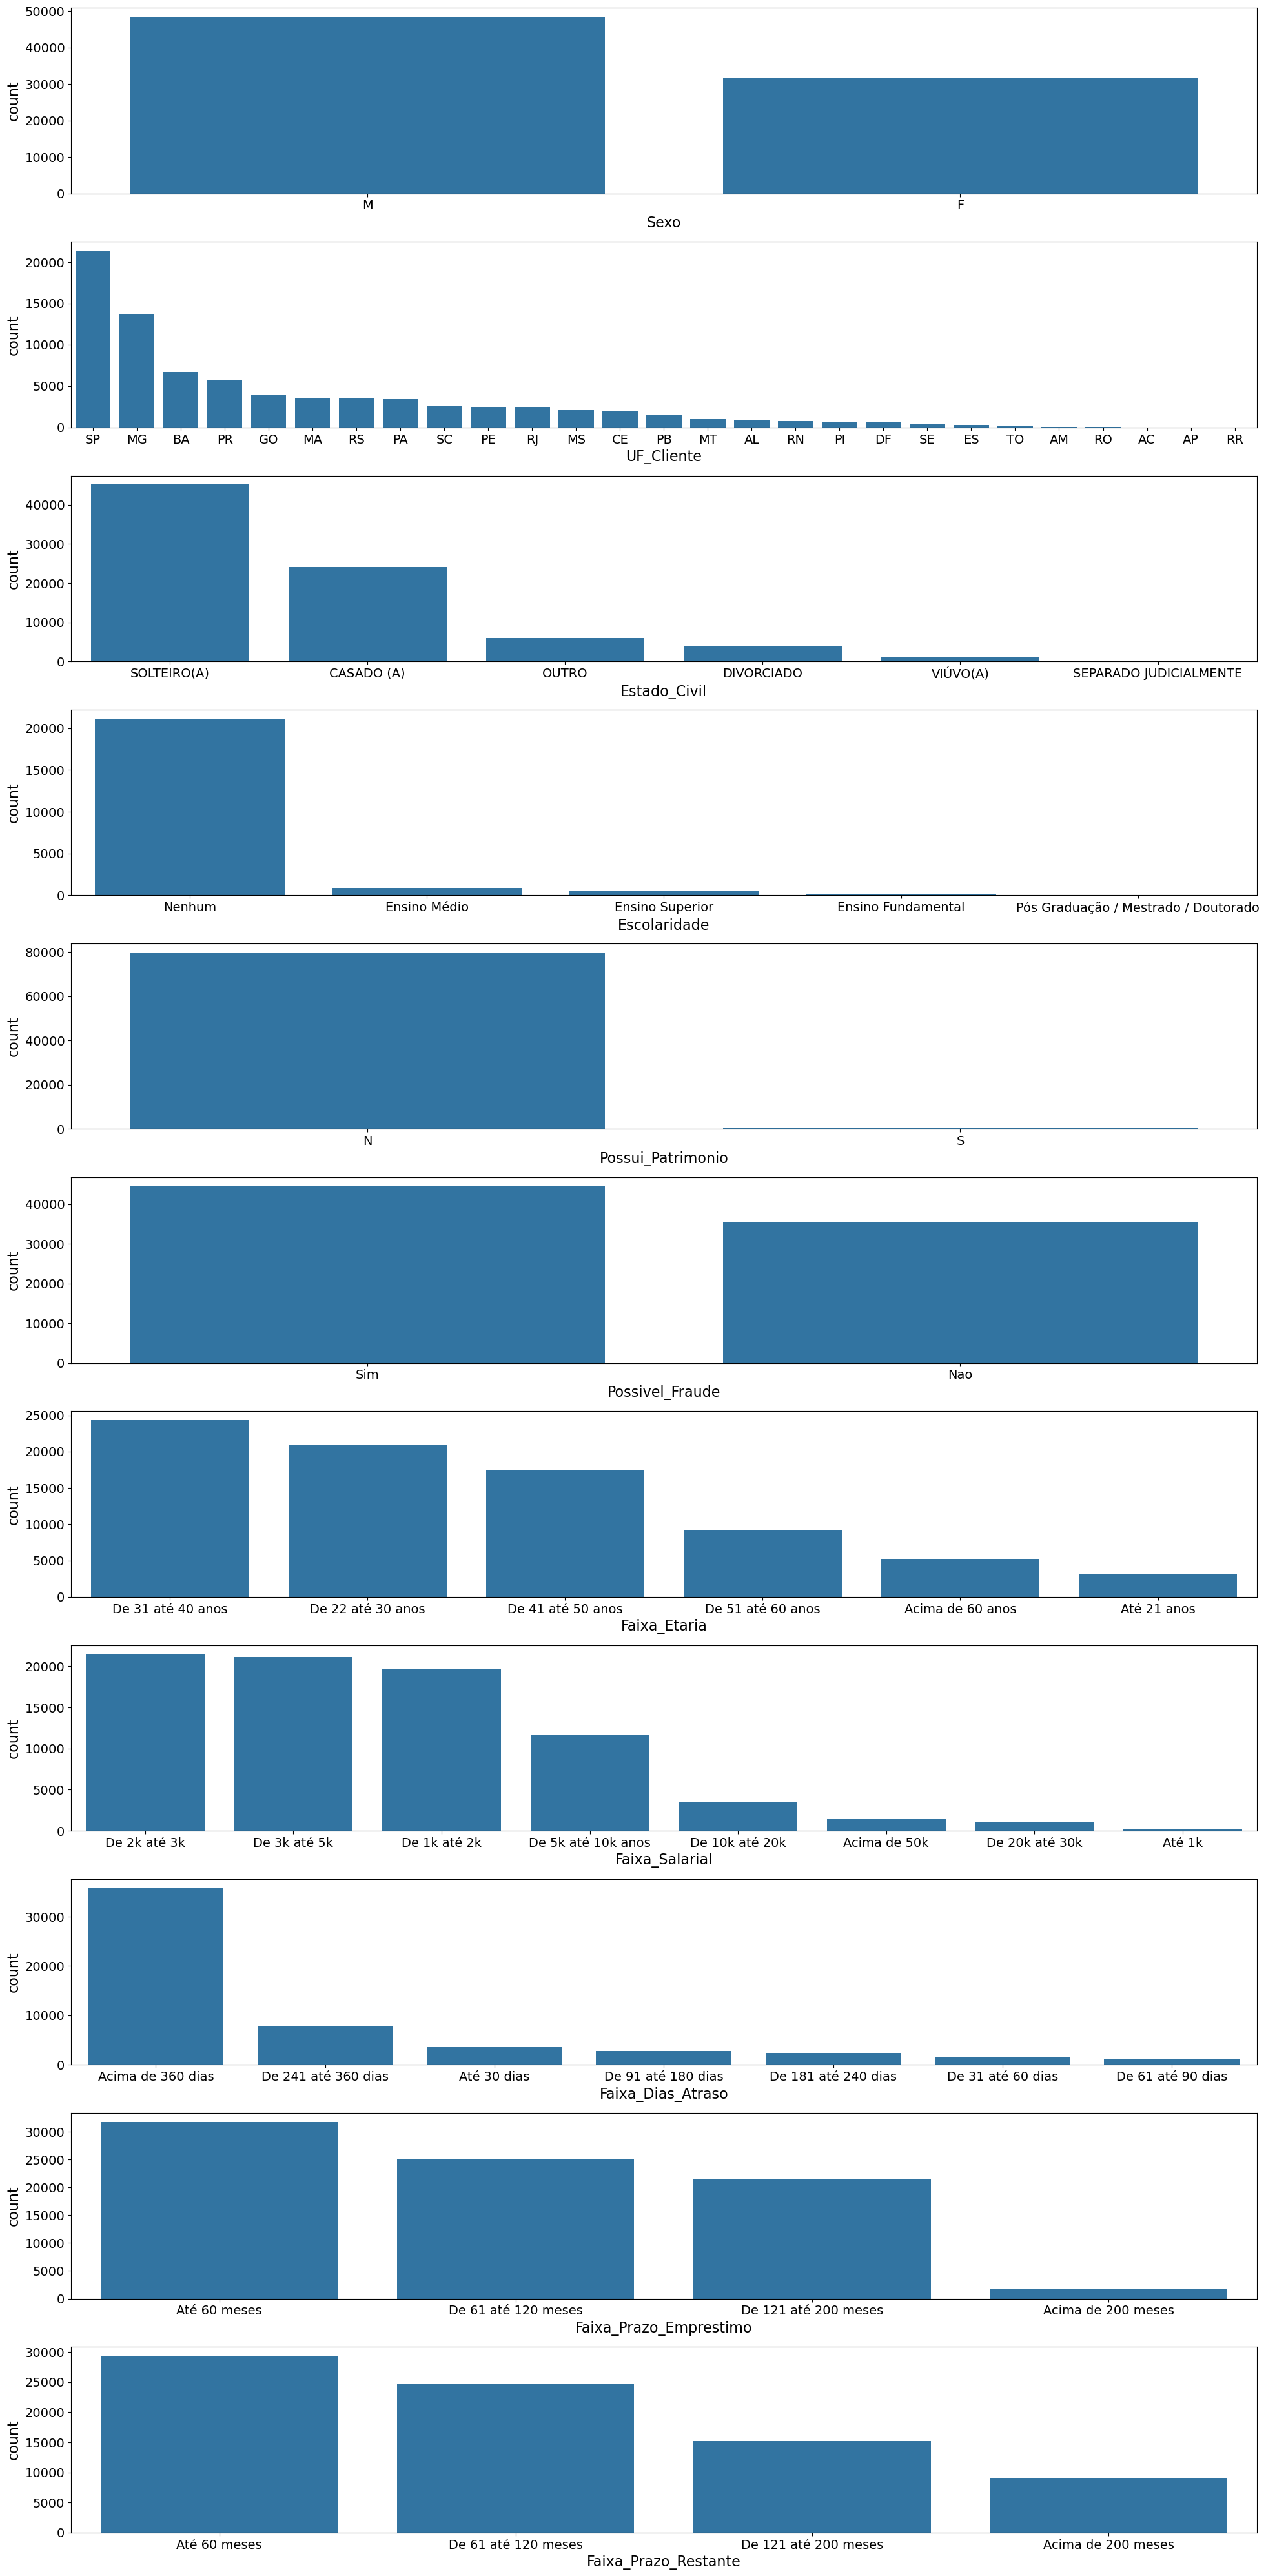

In [32]:
plt.rcParams['figure.figsize'] = [20.00, 40.00]
plt.rcParams['figure.autolayout'] = True
f, axes = plt.subplots(11, 1)

linha = 0
for i in categoricas:
    ordem = df[i].value_counts().sort_values(ascending=False).index
    sns.countplot(data=df, x=i, order=ordem, ax=axes[linha])
    axes[linha].set_ylabel(axes[linha].get_ylabel(), fontsize=16)
    axes[linha].set_xlabel(axes[linha].get_xlabel(), fontsize=16)
    axes[linha].tick_params(axis='x', labelsize=14)  # Aumentando os rótulos do eixo X (categorias)
    axes[linha].tick_params(axis='y', labelsize=14)  # Aumentando os rótulos do eixo Y (frequências)
    linha += 1
     
plt.show()

### Avaliando colunas que usaremos para nossa análise
Após análise, descartaremos as colunas:

* Contrato
* Data_Contratacao
* VL_Patrimonio
* Escolaridade
* Idade (transformado em faixa etária)
* Valor_Renda (transformado em faixa salarial)
* Prazo_Emprestimo (transformado em faixa de prazo de empréstimo)
* QT_Dias_Atraso (transformado em faixa de dias de atraso)
* Prazo_Restante (transformado em faixa de prazo restante)

In [33]:
# Criando novo dataframe, apenas com as colunas que vamos utilizar

# Selecionando colunas
columns = ['Sexo', 'UF_Cliente', 'Perc_Juros', 
       'VL_Emprestimo', 'VL_Emprestimo_ComJuros', 'QT_Total_Parcelas_Pagas',
       'QT_Total_Parcelas_Pagas_EmDia', 'QT_Total_Parcelas_Pagas_EmAtraso',
       'Qt_Renegociacao', 'Estado_Civil', 'QT_Parcelas_Atraso', 'Saldo_Devedor', 
       'Total_Pago', 'Faixa_Prazo_Restante', 'Faixa_Salarial', 'Faixa_Prazo_Emprestimo', 'Faixa_Etaria', 
       'Faixa_Dias_Atraso', 'Possivel_Fraude']

df_tratado = pd.DataFrame(df, columns=columns)

In [34]:
# Shape do novo dataframe
df_tratado.shape

(80143, 19)

In [35]:
# Tipo dos dados
df_tratado.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80143 entries, 0 to 80142
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Sexo                              80143 non-null  object  
 1   UF_Cliente                        80143 non-null  object  
 2   Perc_Juros                        80143 non-null  float64 
 3   VL_Emprestimo                     80143 non-null  float64 
 4   VL_Emprestimo_ComJuros            80143 non-null  float64 
 5   QT_Total_Parcelas_Pagas           80143 non-null  int64   
 6   QT_Total_Parcelas_Pagas_EmDia     80143 non-null  int64   
 7   QT_Total_Parcelas_Pagas_EmAtraso  80143 non-null  int64   
 8   Qt_Renegociacao                   80143 non-null  int64   
 9   Estado_Civil                      80143 non-null  object  
 10  QT_Parcelas_Atraso                80143 non-null  int64   
 11  Saldo_Devedor                     80143 non-null  floa

In [36]:
# Verificando se há valores nulos
df_tratado.isnull().sum()

Sexo                                    0
UF_Cliente                              0
Perc_Juros                              0
VL_Emprestimo                           0
VL_Emprestimo_ComJuros                  0
QT_Total_Parcelas_Pagas                 0
QT_Total_Parcelas_Pagas_EmDia           0
QT_Total_Parcelas_Pagas_EmAtraso        0
Qt_Renegociacao                         0
Estado_Civil                            0
QT_Parcelas_Atraso                      0
Saldo_Devedor                           0
Total_Pago                              0
Faixa_Prazo_Restante                 1638
Faixa_Salarial                         46
Faixa_Prazo_Emprestimo                  0
Faixa_Etaria                            1
Faixa_Dias_Atraso                   25110
Possivel_Fraude                         0
dtype: int64

In [37]:
# Verificando dados estatísticos
df_tratado.describe()

,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago
count,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00,80143.00
mean,19.49,72847.78,83774.94,10.71,5.24,2.34,1.30,10.65,78622.32,9687.98
std,3.56,87407.93,100519.12,9.31,6.21,3.97,1.27,10.43,102318.95,19090.62
min,4.49,3000.00,3450.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,18.00,15000.00,17250.00,2.00,1.00,0.00,0.00,0.00,12122.76,1052.16
50%,20.00,40000.00,46000.00,8.00,2.00,1.00,1.00,9.00,35489.36,3951.39
75%,21.00,100000.00,115000.00,18.00,7.00,3.00,2.00,20.00,117783.25,10886.24
max,28.00,500000.00,575000.00,66.00,66.00,31.00,38.00,34.00,626261.27,465821.39


In [38]:
# Verificando valores únicos
valores_unicos = []
for i in df_tratado.columns[0:19].tolist():
    print(i, ':', len(df_tratado[i].astype(str).value_counts()))
    valores_unicos.append(len(df_tratado[i].astype(str).value_counts()))

Sexo : 2
UF_Cliente : 27
Perc_Juros : 53
VL_Emprestimo : 73
VL_Emprestimo_ComJuros : 73
QT_Total_Parcelas_Pagas : 50
QT_Total_Parcelas_Pagas_EmDia : 48
QT_Total_Parcelas_Pagas_EmAtraso : 32
Qt_Renegociacao : 15
Estado_Civil : 6
QT_Parcelas_Atraso : 35
Saldo_Devedor : 64166
Total_Pago : 54074
Faixa_Prazo_Restante : 5
Faixa_Salarial : 9
Faixa_Prazo_Emprestimo : 4
Faixa_Etaria : 7
Faixa_Dias_Atraso : 8
Possivel_Fraude : 2


### Analisando graficamento as variáveis numéricas

In [41]:
# Inserindo as variáveis numéricas numa lista
numericas = []
for i in df_tratado.columns[0:19].tolist():
    if df_tratado.dtypes[i] == 'int64' or df_tratado.dtypes[i] == 'float64':
        numericas.append(i)

numericas

['Perc_Juros',
 'VL_Emprestimo',
 'VL_Emprestimo_ComJuros',
 'QT_Total_Parcelas_Pagas',
 'QT_Total_Parcelas_Pagas_EmDia',
 'QT_Total_Parcelas_Pagas_EmAtraso',
 'Qt_Renegociacao',
 'QT_Parcelas_Atraso',
 'Saldo_Devedor',
 'Total_Pago']

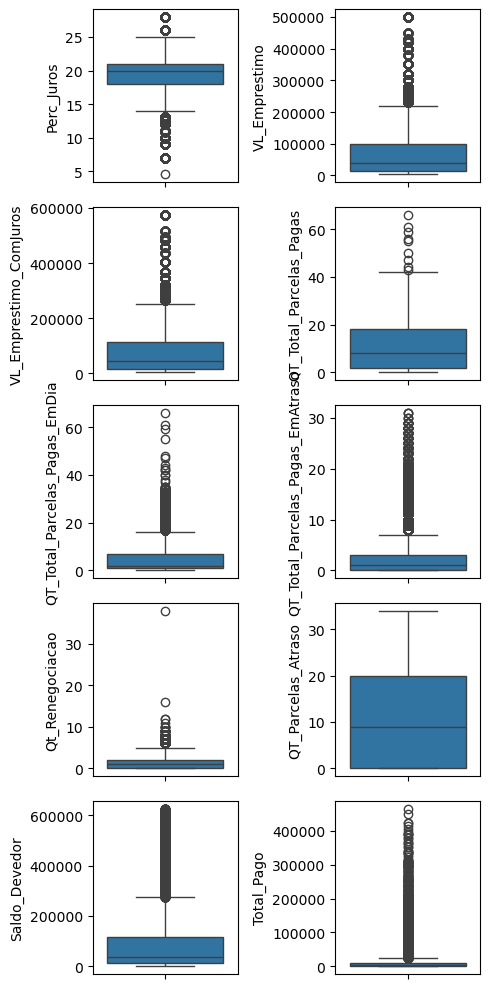

In [43]:
# Criando boxplots com as variáveis numéricas para identificar possíveis outliers
# Os valores indicados como outliers nos gráficos podem ser considerados normais dado o contexto dos dados, não há necessidade de tratamento.
plt.rcParams['figure.figsize'] = [5, 10]
plt.rcParams['figure.autolayout'] = True
f, axes = plt.subplots(5, 2)

linha = 0
coluna = 0
for i in numericas:
    sns.boxplot(data = df_tratado, y=i, ax=axes[linha][coluna])
    coluna +=1
    if coluna == 2:
        linha += 1
        coluna = 0
plt.show()

### Codificação de variáveis categóricas (One-Hot Encoding)

In [44]:
# Carregando variáveis categóricas para OneHotEncoding, exceto a variável target
categoricas = []
for i in df_tratado.columns[0:18].tolist():
    if df_tratado.dtypes[i] == 'object' or df_tratado.dtypes[i] == 'category':
        categoricas.append(i)

In [45]:
# Criando o encoder e aplicando o OneHotEncoder
lb = LabelEncoder()

for var in categoricas:
    df_tratado[var] = lb.fit_transform(df_tratado[var])

In [46]:
# Verificando existência de nulos após transformação
df_tratado.isnull().sum()

Sexo                                0
UF_Cliente                          0
Perc_Juros                          0
VL_Emprestimo                       0
VL_Emprestimo_ComJuros              0
QT_Total_Parcelas_Pagas             0
QT_Total_Parcelas_Pagas_EmDia       0
QT_Total_Parcelas_Pagas_EmAtraso    0
Qt_Renegociacao                     0
Estado_Civil                        0
QT_Parcelas_Atraso                  0
Saldo_Devedor                       0
Total_Pago                          0
Faixa_Prazo_Restante                0
Faixa_Salarial                      0
Faixa_Prazo_Emprestimo              0
Faixa_Etaria                        0
Faixa_Dias_Atraso                   0
Possivel_Fraude                     0
dtype: int64

In [47]:
# Verificando dados
df_tratado.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Faixa_Prazo_Restante,Faixa_Salarial,Faixa_Prazo_Emprestimo,Faixa_Etaria,Faixa_Dias_Atraso,Possivel_Fraude
0,1,9,17.00,160000.00,184000.00,2,1,1,2,4,10,187861.70,1617.36,2,6,2,4,3,Sim
1,1,9,20.00,14000.00,16100.00,2,1,1,1,0,26,16615.93,1239.98,1,5,1,3,7,Sim
2,0,25,24.00,60000.00,69000.00,4,1,0,1,0,27,74443.40,1346.64,2,5,2,3,7,Sim
3,1,6,19.00,180000.00,207000.00,29,28,0,2,4,2,196812.41,22713.63,2,5,2,2,4,Nao
4,0,10,22.00,30000.00,34500.00,4,3,0,1,4,6,36114.39,900.80,3,6,3,1,6,Sim


In [48]:
# Visualizando tipo das variáveis
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80143 entries, 0 to 80142
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sexo                              80143 non-null  int32  
 1   UF_Cliente                        80143 non-null  int32  
 2   Perc_Juros                        80143 non-null  float64
 3   VL_Emprestimo                     80143 non-null  float64
 4   VL_Emprestimo_ComJuros            80143 non-null  float64
 5   QT_Total_Parcelas_Pagas           80143 non-null  int64  
 6   QT_Total_Parcelas_Pagas_EmDia     80143 non-null  int64  
 7   QT_Total_Parcelas_Pagas_EmAtraso  80143 non-null  int64  
 8   Qt_Renegociacao                   80143 non-null  int64  
 9   Estado_Civil                      80143 non-null  int32  
 10  QT_Parcelas_Atraso                80143 non-null  int64  
 11  Saldo_Devedor                     80143 non-null  float64
 12  Tota

 ### Divisão em treino e teste

In [50]:
# Separando as variáveis em preditoras e target
PREDITORAS = df_tratado.iloc[:, 0:18]
TARGET = df_tratado.iloc[:, 18]

In [51]:
# Visualizando preditoras
PREDITORAS.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Faixa_Prazo_Restante,Faixa_Salarial,Faixa_Prazo_Emprestimo,Faixa_Etaria,Faixa_Dias_Atraso
0,1,9,17.00,160000.00,184000.00,2,1,1,2,4,10,187861.70,1617.36,2,6,2,4,3
1,1,9,20.00,14000.00,16100.00,2,1,1,1,0,26,16615.93,1239.98,1,5,1,3,7
2,0,25,24.00,60000.00,69000.00,4,1,0,1,0,27,74443.40,1346.64,2,5,2,3,7
3,1,6,19.00,180000.00,207000.00,29,28,0,2,4,2,196812.41,22713.63,2,5,2,2,4
4,0,10,22.00,30000.00,34500.00,4,3,0,1,4,6,36114.39,900.80,3,6,3,1,6


In [52]:
# Visualizando target
TARGET.head()

0    Sim
1    Sim
2    Sim
3    Nao
4    Sim
Name: Possivel_Fraude, dtype: object

### Balanceamento dos dados

In [49]:
# Visualizando quantidade de dados na variável target
var_target = df_tratado.Possivel_Fraude.value_counts()
var_target

Possivel_Fraude
Sim    44511
Nao    35632
Name: count, dtype: int64

In [53]:
# Para reproduzir o mesmo resultado
seed = 100

# Balanceador SMOTE
balanceador = SMOTE(random_state = seed)

# Aplicando o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS, TARGET)

<Axes: title={'center': 'Possíveis Fraudes X Não Fraudes'}, xlabel='Possivel_Fraude'>

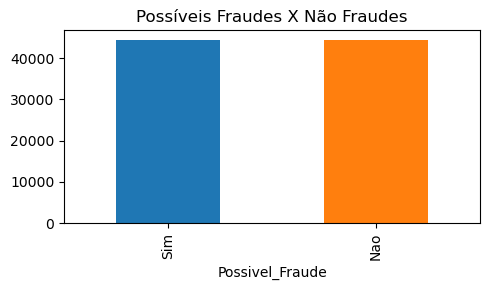

In [58]:
# Visualizando a varivável target balanceada
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.autolayout'] = True
TARGET_RES.value_counts().plot(kind='bar', title='Possíveis Fraudes X Não Fraudes', color=['#1F77B4', '#FF7F0E'])

In [59]:
# Total registros antes do balanceamento - Preditoras
PREDITORAS.shape

(80143, 18)

In [60]:
# Total registros depois do balanceamento - Target
TARGET.shape

(80143,)

In [61]:
# Total registros antes do balanceamento - Preditoras
PREDITORAS_RES.shape

(89022, 18)

In [62]:
# Total registros depois do balanceamento - Target
TARGET_RES.shape

(89022,)

#### Divisão em Treino e Teste

In [63]:
# Divisão entre treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size=0.3, random_state=42)

In [64]:
# Verificando treino
X_treino.shape

(62315, 18)

### Normalização as Variáveis

In [65]:
# Normalização das variáveis
normalizador = MinMaxScaler()
X_treino_normalizado = normalizador.fit_transform(X_treino)
X_teste_normalizado = normalizador.transform(X_teste)

In [66]:
# Visualizando dados normalizados
X_treino_normalizado

array([[1.        , 0.15384615, 0.52380952, ..., 1.        , 0.5       ,
        0.        ],
       [0.        , 0.30769231, 0.52380952, ..., 0.33333333, 0.66666667,
        0.        ],
       [1.        , 0.34615385, 0.38095238, ..., 0.66666667, 0.66666667,
        0.        ],
       ...,
       [1.        , 0.96153846, 0.52380952, ..., 0.66666667, 0.5       ,
        1.        ],
       [1.        , 0.19230769, 0.52380952, ..., 1.        , 0.66666667,
        0.        ],
       [0.        , 0.15384615, 0.61904762, ..., 0.66666667, 0.33333333,
        1.        ]])

### Padronização das Variáveis

In [67]:
# Padronizando
padronizador = StandardScaler()
X_treino_padronizado = padronizador.fit_transform(X_treino)
X_teste_padronizado = padronizador.transform(X_teste)

In [68]:
# Visualizando dados padronizados
X_treino_padronizado

array([[ 0.84452433, -1.53145018, -0.40217896, ...,  1.29206431,
         0.09190767, -0.88774635],
       [-1.18409851, -0.99431095, -0.40217896, ..., -0.97807377,
         0.87742768, -0.88774635],
       [ 0.84452433, -0.86002615, -1.23927589, ...,  0.15699527,
         0.87742768, -0.88774635],
       ...,
       [ 0.84452433,  1.28853077, -0.40217896, ...,  0.15699527,
         0.09190767,  1.40392291],
       [ 0.84452433, -1.39716537, -0.40217896, ...,  1.29206431,
         0.87742768, -0.88774635],
       [-1.18409851, -1.53145018,  0.15588566, ...,  0.15699527,
        -0.69361234,  1.40392291]])

### Encontrando o Melhor Modelo de Machine Learning
Vamos criar, treinar e avaliar diferentes modelos de machine learning, sendo eles:
* Random Forest
* SVM
* KNN

#### Random Forest

In [69]:
# Construtor do modelo
randomForest = RandomForestClassifier()

In [70]:
# Parâmetros default
randomForest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Valores para o grid de hiperparâmetros
n_estimators = np.array([100,200,300])
max_depth = np.array([10,20])
criterion = np.array(["gini", "entropy"])
max_features = np.array(["sqrt", "log2", None])
min_samples_split = np.array([2,5])
min_samples_leaf = np.array([1,2,3])


# Grid de hiperparâmetros
grid_parametros = dict(n_estimators = n_estimators,
                       max_depth = max_depth,
                       criterion = criterion,
                       max_features = max_features,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf)

# Criando o modelo com o Grid de Hiperparametros
randomForest = GridSearchCV(RandomForestClassifier(), grid_parametros, cv=3, n_jobs=3)

# Treinando os modelos
inicio = time.time()
randomForest.fit(X_treino_normalizado, Y_treino)
fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_rf = pd.DataFrame(randomForest.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {randomForest.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {randomForest.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Número de Treinamentos Realizados: ", treinos_rf.shape[0])

In [ ]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_jobs=3)

# Construção do modelo
clf = clf.fit(X_treino_normalizado, Y_treino)

In [ ]:
# Exibindo a importância das variáveis no modelo preditivo
plt.rcParams['figure.figsize'] = [8.00, 6.00]
plt.rcParams['figure.autolayout'] = True

importances = pd.Series(data=clf.feature_importances_, index=PREDITORAS.columns)
importances = importances.sort_values(ascending=False)

sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de Cada Variável')
plt.show()

In [ ]:
# Visualizando o percentual de importância de cada variável
# As variáveis com percentual 0 podem ser posteriormente removidas, pois não têm importância em nosso modelo
importances.sort_values(ascending=False)

In [ ]:
# Criando dicionário de métricas e metadados
modelo_rf = {'Melhores Hiperparâmetros':randomForest.best_params_,
            'Número de Modelos Treinados':treinos_rf.shape[0],
            'Melhor Score':str(round(randomForest.best_score_ * 100,2))+'%'}

In [ ]:
modelo_rf

In [ ]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_jobs=3)

# Construção do modelo
clf = clf.fit(X_treino_normalizado, Y_treino)

In [ ]:
# Score variável treino
scores = clf.score(X_treino_normalizado, Y_treino)
scores

In [ ]:
# Score variável teste
scores = clf.score(X_teste_normalizado, Y_teste)
scores

#### SVM

In [ ]:
# Construtor do modelo
modelo_svm = SVC()

In [ ]:
# Parâmetros default
modelo_svm.get_params()

In [ ]:
# Valores para o grid de hiperparâmetros
grid_parametros = {'C':[0.1, 1, 10, 100],
                  'gamma':[1, 0.1, 0.01, 0.001],
                  #'kernel':['poly', 'rbf', 'sigmoid', 'linear'],
                  'degree':[2, 3, 4],
                  'coef0':[0.5, 1],
                  #'decision_function_shape':['ovo', 'ovr'],
                  'max_iter':[-1,1]}

svm = GridSearchCV(modelo_svm, grid_parametros, n_jobs=3)

# Treinando os modelos
inicio = time.time()
svm.fit(X_treino_normalizado, Y_treino)
fim = time.time()

# Obtendo e visualizando os parâmetros treinoados
treinos_svm = pd.DataFrame(svm.cv_results_)


# Acurácia em Treino
print(f"Acurácia em Treinamento: {svm.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {svm.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Número de Treinamentos Realizados: ", treinos_svm.shape[0])

In [ ]:
# Dicionário de métricas e metadados
modelo_svm = {'Melhores Hiperparâmetros':svm.best_params_,
               'Número de Modelos Treinados': treinos_svm.shape[0],  
               'Melhor Score': str(round(svm.best_score_ * 100,2))+"%"}

In [ ]:
modelo_svm

#### KNN

In [ ]:
# Classificador
knn = KNeighborsClassifier()

In [ ]:
# Parametros default
knn.get_params()

In [ ]:
# Valores para o grid de hiperparametros
n_neighbors = np.array([3, 4, 5, 6, 7])
algorithm = np.array(['auto', 'ball_tree', 'kd_tree', 'brute'])
leaf_size = np.array([30, 31, 32])
metric =  np.array(['minkowski', 'euclidean'])


# Grid de hiperparâmetros
grid_parametros = dict(n_neighbors = n_neighbors,
                       algorithm = algorithm,
                       leaf_size = leaf_size,
                       metric = metric)

knn = GridSearchCV(knn, grid_parametros, n_jobs=3)

# Treinando os modelos
inicio = time.time()
knn.fit(X_treino_normalizado, Y_treino)
fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_knn = pd.DataFrame(knn.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {knn.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {knn.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Número de Treinamentos Realizados: ", treinos_knn.shape[0])

In [ ]:
# Dicionário de métricas e metadados
modelo_knn = {'Melhores Hiperparâmetros':knn.best_params_,
               'Número de Modelos Treinados': treinos_knn.shape[0],  
               'Melhor Score': str(round(knn.best_score_ * 100,2))+"%"}

In [ ]:
modelo_knn

In [ ]:
# Gerando o DataFrame com todos os valores de todos os modelos treinados
resumo = pd.DataFrame({'Random Forest':pd.Series(modelo_rf),
                       'SVM':pd.Series(modelo_svm),                       
                       'KNN':pd.Series(modelo_knn)
                      })

In [ ]:
resumo